# 必要モジュールのインストール & インポート

In [1]:
!pip install japanize_matplotlib numpyro

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.1/348.1 kB 9.8 MB/s eta 0:00:00
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=8ef35a2ac7ef682f04476655ee09c990e9b476bb44a5b812fa52ba569c42b1d3
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize_matplotlib


In [2]:
import urllib
import datetime
import re
import sys
import time
from collections import defaultdict

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import networkx as nx
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from bs4 import BeautifulSoup
from numpyro.infer import DiscreteHMCGibbs, MCMC, NUTS

# データの取得

In [3]:
word = "リコリス・リコイル"

In [4]:
word_quoted = urllib.parse.quote(word)
res_num = 1
posts = []

# 他人に投稿を飛ばした回数とか
# レス番号のサニタイズ

while True:
    sys.stdout.write(f"\r{res_num}")
    url = f"https://dic.nicovideo.jp/b/a/{word_quoted}/{res_num}-"
    res = requests.get(url)

    if res.status_code != 200:
      continue

    bs = BeautifulSoup(res.text, "html.parser")

    heads = bs.find_all("dt", class_="st-bbs_reshead")
    bodies = bs.find_all("dd", class_="st-bbs_resbody")

    for head, body in zip(heads, bodies):

        info = head.find("div", "st-bbs_resInfo").text
        date_and_id = list(map(lambda x: x.strip(), info.strip().split("\n")))

        if date_and_id[0] == "削除しました":
            continue

        responses = body.find_all(lambda tag:
                            tag.name == 'a' and
                            tag.get('class') == ['dic'] and
                            re.match('>>(\d+)', tag.get_text()))
        # responses = body.find_all("a", class_="dic")
        responses = list(map(lambda x: int(re.match(">>(\d+)", x.text).group(1)), responses))

        # レス番を削除する
        for r in body.find_all("a", class_="dic"):
          r.decompose()

        post = {
            "num": int(head.find("span", "st-bbs_resNo").text),
            "name": head.find("span", "st-bbs_name").text,
            "date": datetime.datetime.strptime(re.sub("\(.+\)", "", date_and_id[0]), '%Y/%m/%d %H:%M:%S'),
            "id": date_and_id[3],
            "body": body.text.replace("\n", "").strip(),
            "responses": responses,
        }
        posts.append(post)

    if len(heads) != 30:
        break

    res_num += 30
    time.sleep(0.5)

df = pd.DataFrame.from_dict(posts)
df["date"] = pd.to_datetime(df["date"])
display(df)

3481

,num,name,date,id,body,responses
0,1,ななしのよっしん,2022-06-12 17:20:03,ID: 6/mYyHiM3v,これオリジナルアニメなのか。だいぶべたな設定だけどどうなるかな？,[]
1,2,ななしのよっしん,2022-06-12 20:49:21,ID: 8ciBIQZH89,先行上映を見た人のツイートと新ビジュアル見るに、ほのぼの喫茶店の解決屋ではない・・・？,[]
2,3,ななしのよっしん,2022-06-13 08:36:05,ID: 6/mYyHiM3v,キービジュ2弾で本性表したっぽいが。SAOのスピンオフ企画だけどそれを隠してる？ってことない...,[]
3,4,ななしのよっしん,2022-06-15 20:59:46,ID: LTjJQiXmKQ,ガンアクション版ゆゆゆって言われてて草墨田区の外が全滅してたり、代償を払うのを花に例えるとか...,[]
4,5,ななしのよっしん,2022-06-15 21:03:52,ID: 6/mYyHiM3v,PVが何かおかしいらしいあれ。あとあらすじに違和感あるような。キービジュにキャラがたくさん映...,[]
...,...,...,...,...,...,...
3297,3486,ななしのよっしん,2024-04-09 08:09:10,ID: zzhINtQsl1,この流れでアメコミヒーローの話なんか出すわけないだろう刑事や元CIA、特殊部隊出身みたいな主...,[]
3298,3487,ななしのよっしん,2024-04-10 09:37:53,ID: ttcrAgUT1J,非殺傷弾が出てきた！リアル設定だ！主人公が超人過ぎるのはおかしい！若いね,[]
3299,3488,ななしのよっしん,2024-04-13 21:50:51,ID: sYcUs3W0Mw,いやあ刑事やCIAでも生身で銃弾をヒョイヒョイ避けるのはそうそうないだろせめて物陰に隠れたり...,[]
3300,3489,ななしのよっしん,2024-04-14 00:10:10,ID: Ah3oG60xxb,あの…ハリウッドでシュワちゃんが明らかに銃撃とか食らってるのに平然としてむしろ筋肉で反撃する...,[]


# データ内容のプロット

## 投稿頻度

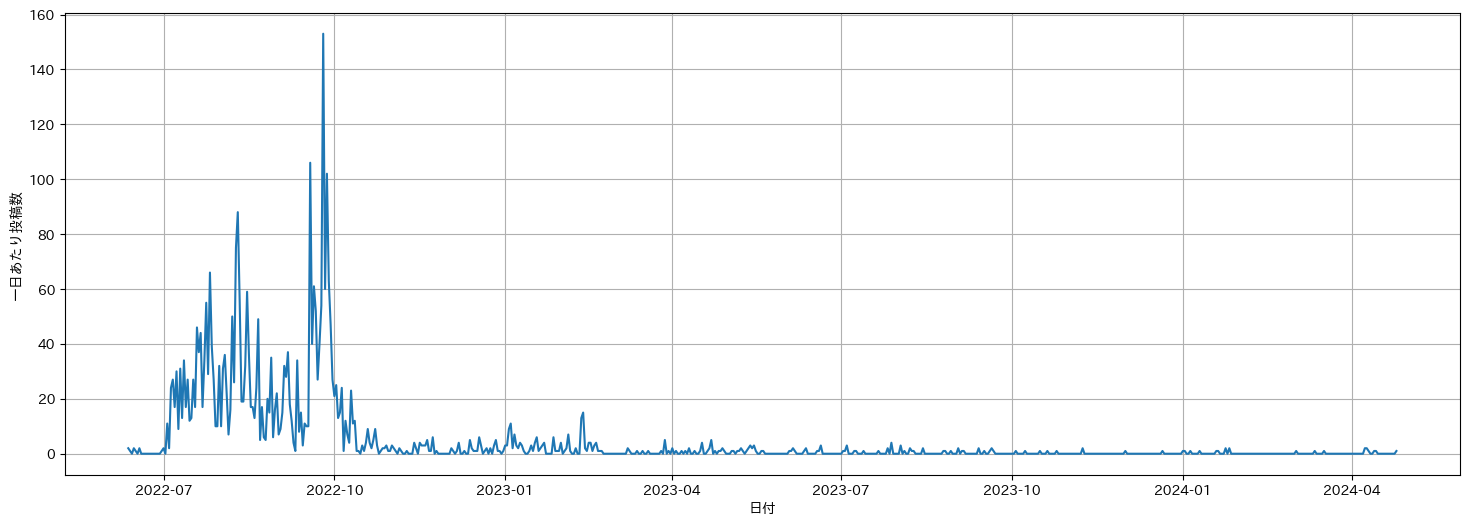

In [5]:
plt.rcParams["figure.figsize"] = (18, 6)

agg = df.groupby(pd.Grouper(key='date', freq='1d')).apply(lambda x: len(x))
plt.grid()
plt.xlabel("日付")
plt.ylabel("一日あたり投稿数")
plt.plot(agg.index, agg)

## レスのやり取り

'relations:'

,from,to
0,ID: OXneaF8t21,ID: wOMK+P000Z
1,ID: 6/mYyHiM3v,ID: cs5aDrU4BN
2,ID: 0yxJP7iKe+,ID: 9Qe3B+yoKG
3,ID: 0yxJP7iKe+,ID: cs5aDrU4BN
4,ID: sfSV7CqMdQ,ID: 9/uDxU+T5z
...,...,...
784,ID: erSqXico+Q,ID: 6Q4HfyWSgR
785,ID: 6VzSfqyL1J,ID: zMxgJBgnCM
786,ID: a1kp3PoEqP,ID: ZkYdTiFqd3
787,ID: M1wFsSK7is,ID: a1kp3PoEqP


'anchor_counts:'

,id,sent,received
48,ID: DJF83CWeVb,47,21
56,ID: HiekEUW+Ku,37,29
8,ID: 0ymNDB/igS,36,15
44,ID: BQKX5zac/P,31,26
9,ID: 0yxJP7iKe+,20,9
...,...,...,...
125,ID: osT5+F2XzG,1,1
130,ID: qyTh1/kIWQ,1,1
136,ID: uSIctMmZrv,1,1
138,ID: wfwIweQRoO,1,1


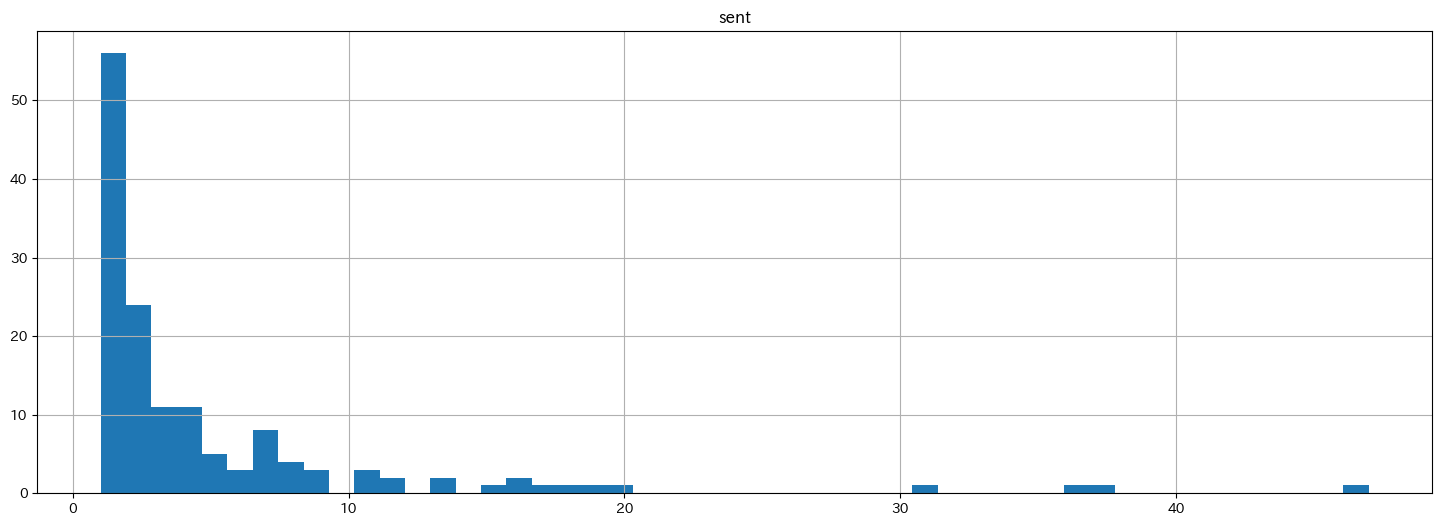

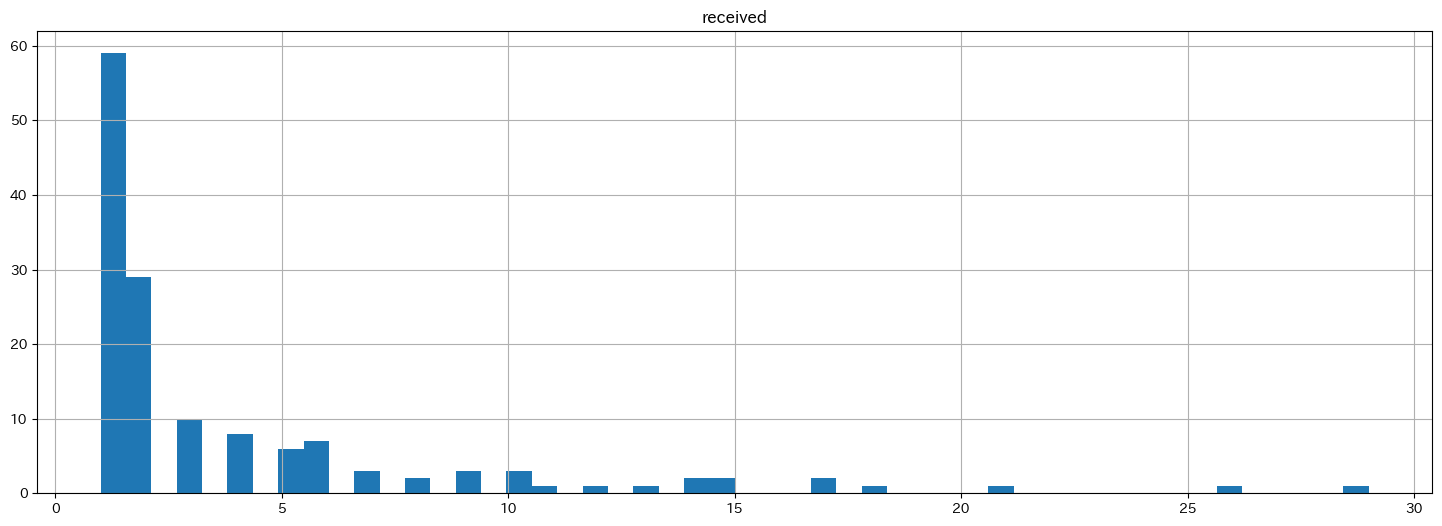

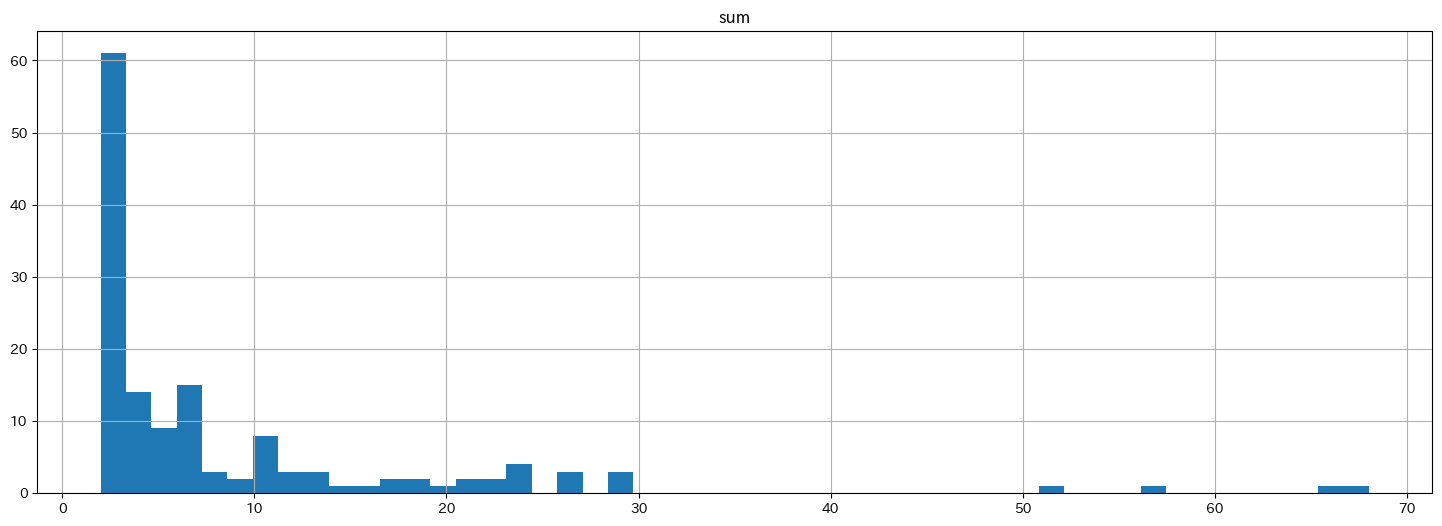

In [6]:
from_ids = []
to_ids = []

for i, row in df.iterrows():
  if len(row["responses"]) == 0:
    continue

  for num_to in row["responses"]:
    row_to = df[df["num"] == num_to]

    # レス対象先が存在しない場合は無視
    if len(row_to) == 0:
      continue

    id_to = row_to.iloc[0, 3]
    id_from = row["id"]

    from_ids.append(id_from)
    to_ids.append(id_to)

relations = pd.DataFrame({"from": from_ids, "to": to_ids})
display("relations:")
display(relations)

sent = relations.groupby(["from"], as_index=False).count().rename(columns={"to": "sent"})
received = relations.groupby(["to"], as_index=False).count().rename(columns={"from": "received"})

anchor_counts = pd.merge(sent, received, left_on="from", right_on="to")
anchor_counts = anchor_counts.drop("to", axis=1).rename(columns={"from": "id"})
anchor_counts = anchor_counts.sort_values(["sent", "received"], ascending=False)
display("anchor_counts:")
display(anchor_counts)

anchor_counts["sum"] = anchor_counts["sent"] + anchor_counts["received"]

anchor_counts["sent"].hist(bins=50)
plt.title("sent")
plt.show()
anchor_counts["received"].hist(bins=50)
plt.title("received")
plt.show()
anchor_counts["sum"].hist(bins=50)
plt.title("sum")
plt.show()

59

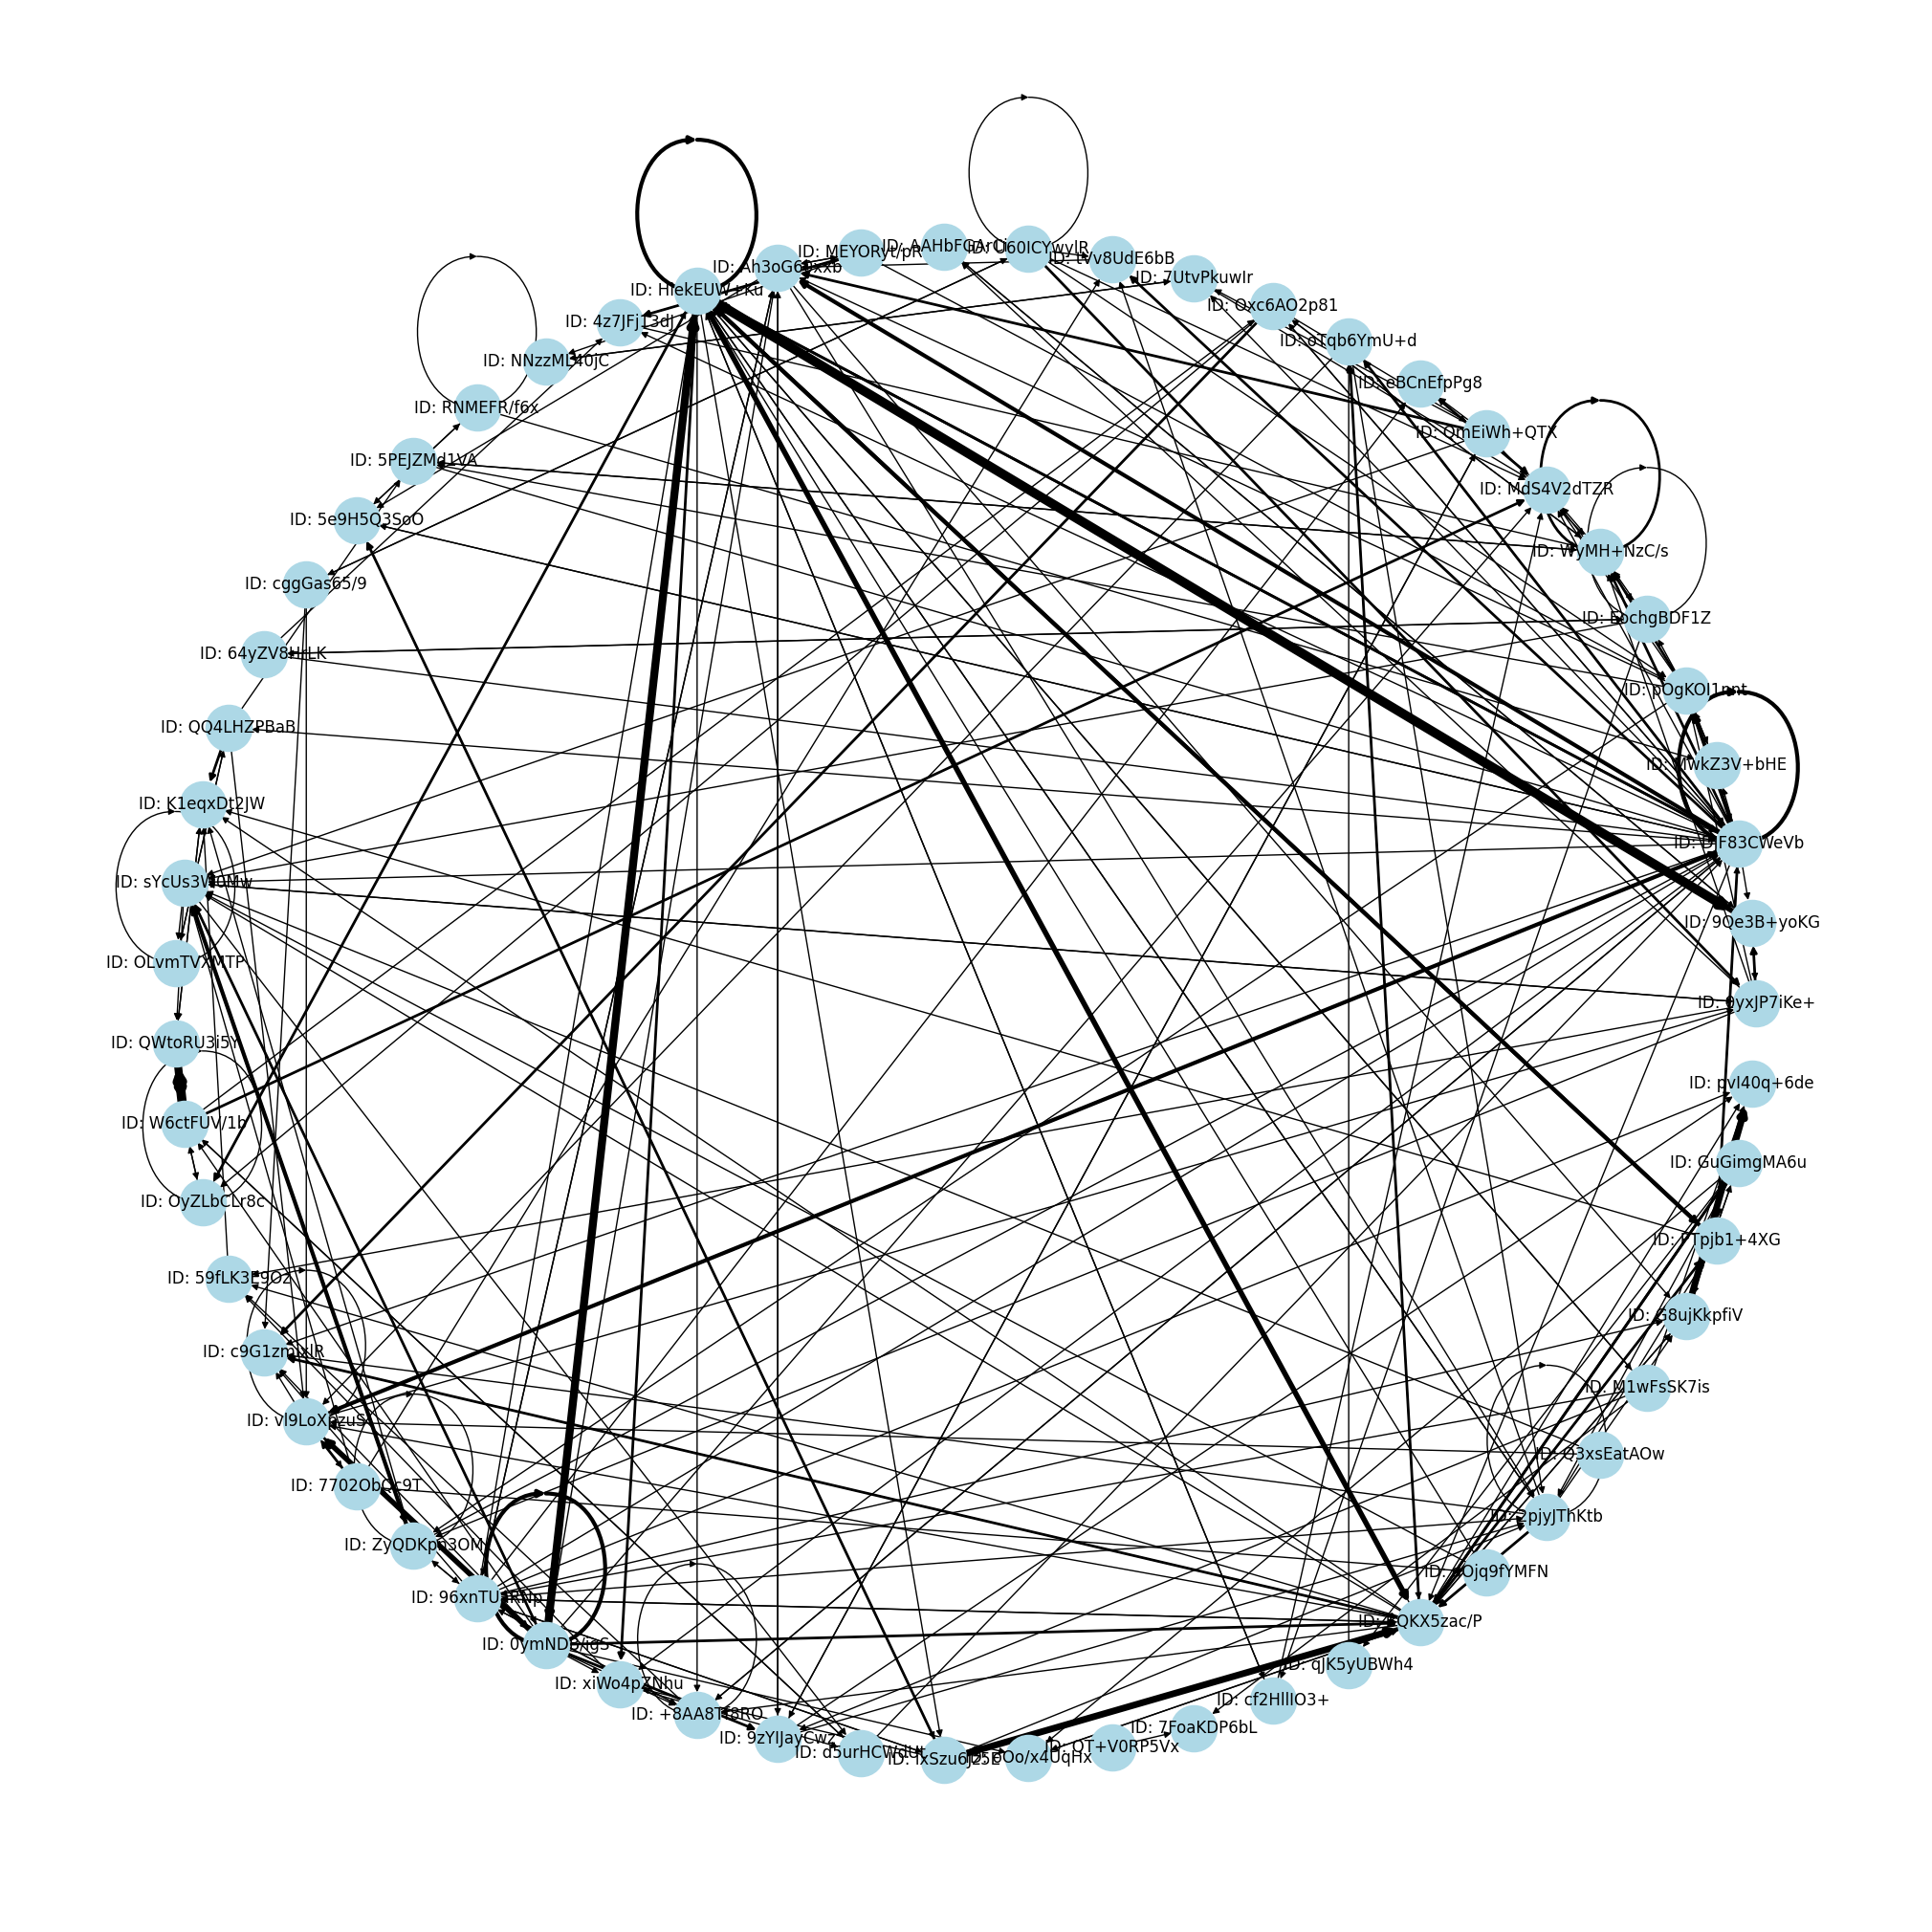

In [7]:
ids = anchor_counts[(anchor_counts["sum"] > 5)]["id"].unique().tolist()
target_relations = relations[relations["from"].isin(ids) & relations["to"].isin(ids)]
target_ids = list(set(target_relations["from"].unique()) | set(target_relations["to"].unique()))
display(len(target_ids))

# 有向グラフの初期化
G = nx.DiGraph()

for i, row in target_relations.iterrows():
  weight = 0
  if row["from"] in G and row["to"] in G[row["from"]]:
    weight = G[row["from"]][row["to"]].get('weight', 0)
  G.add_edge(row["from"], row["to"], weight=weight+1)

plt.figure(figsize=(20, 20))
weights = [G[u][v]['weight'] for u,v in G.edges()]
nx.draw_circular(G, with_labels=True, node_color='lightblue', node_size=1200, width=weights)
plt.show()

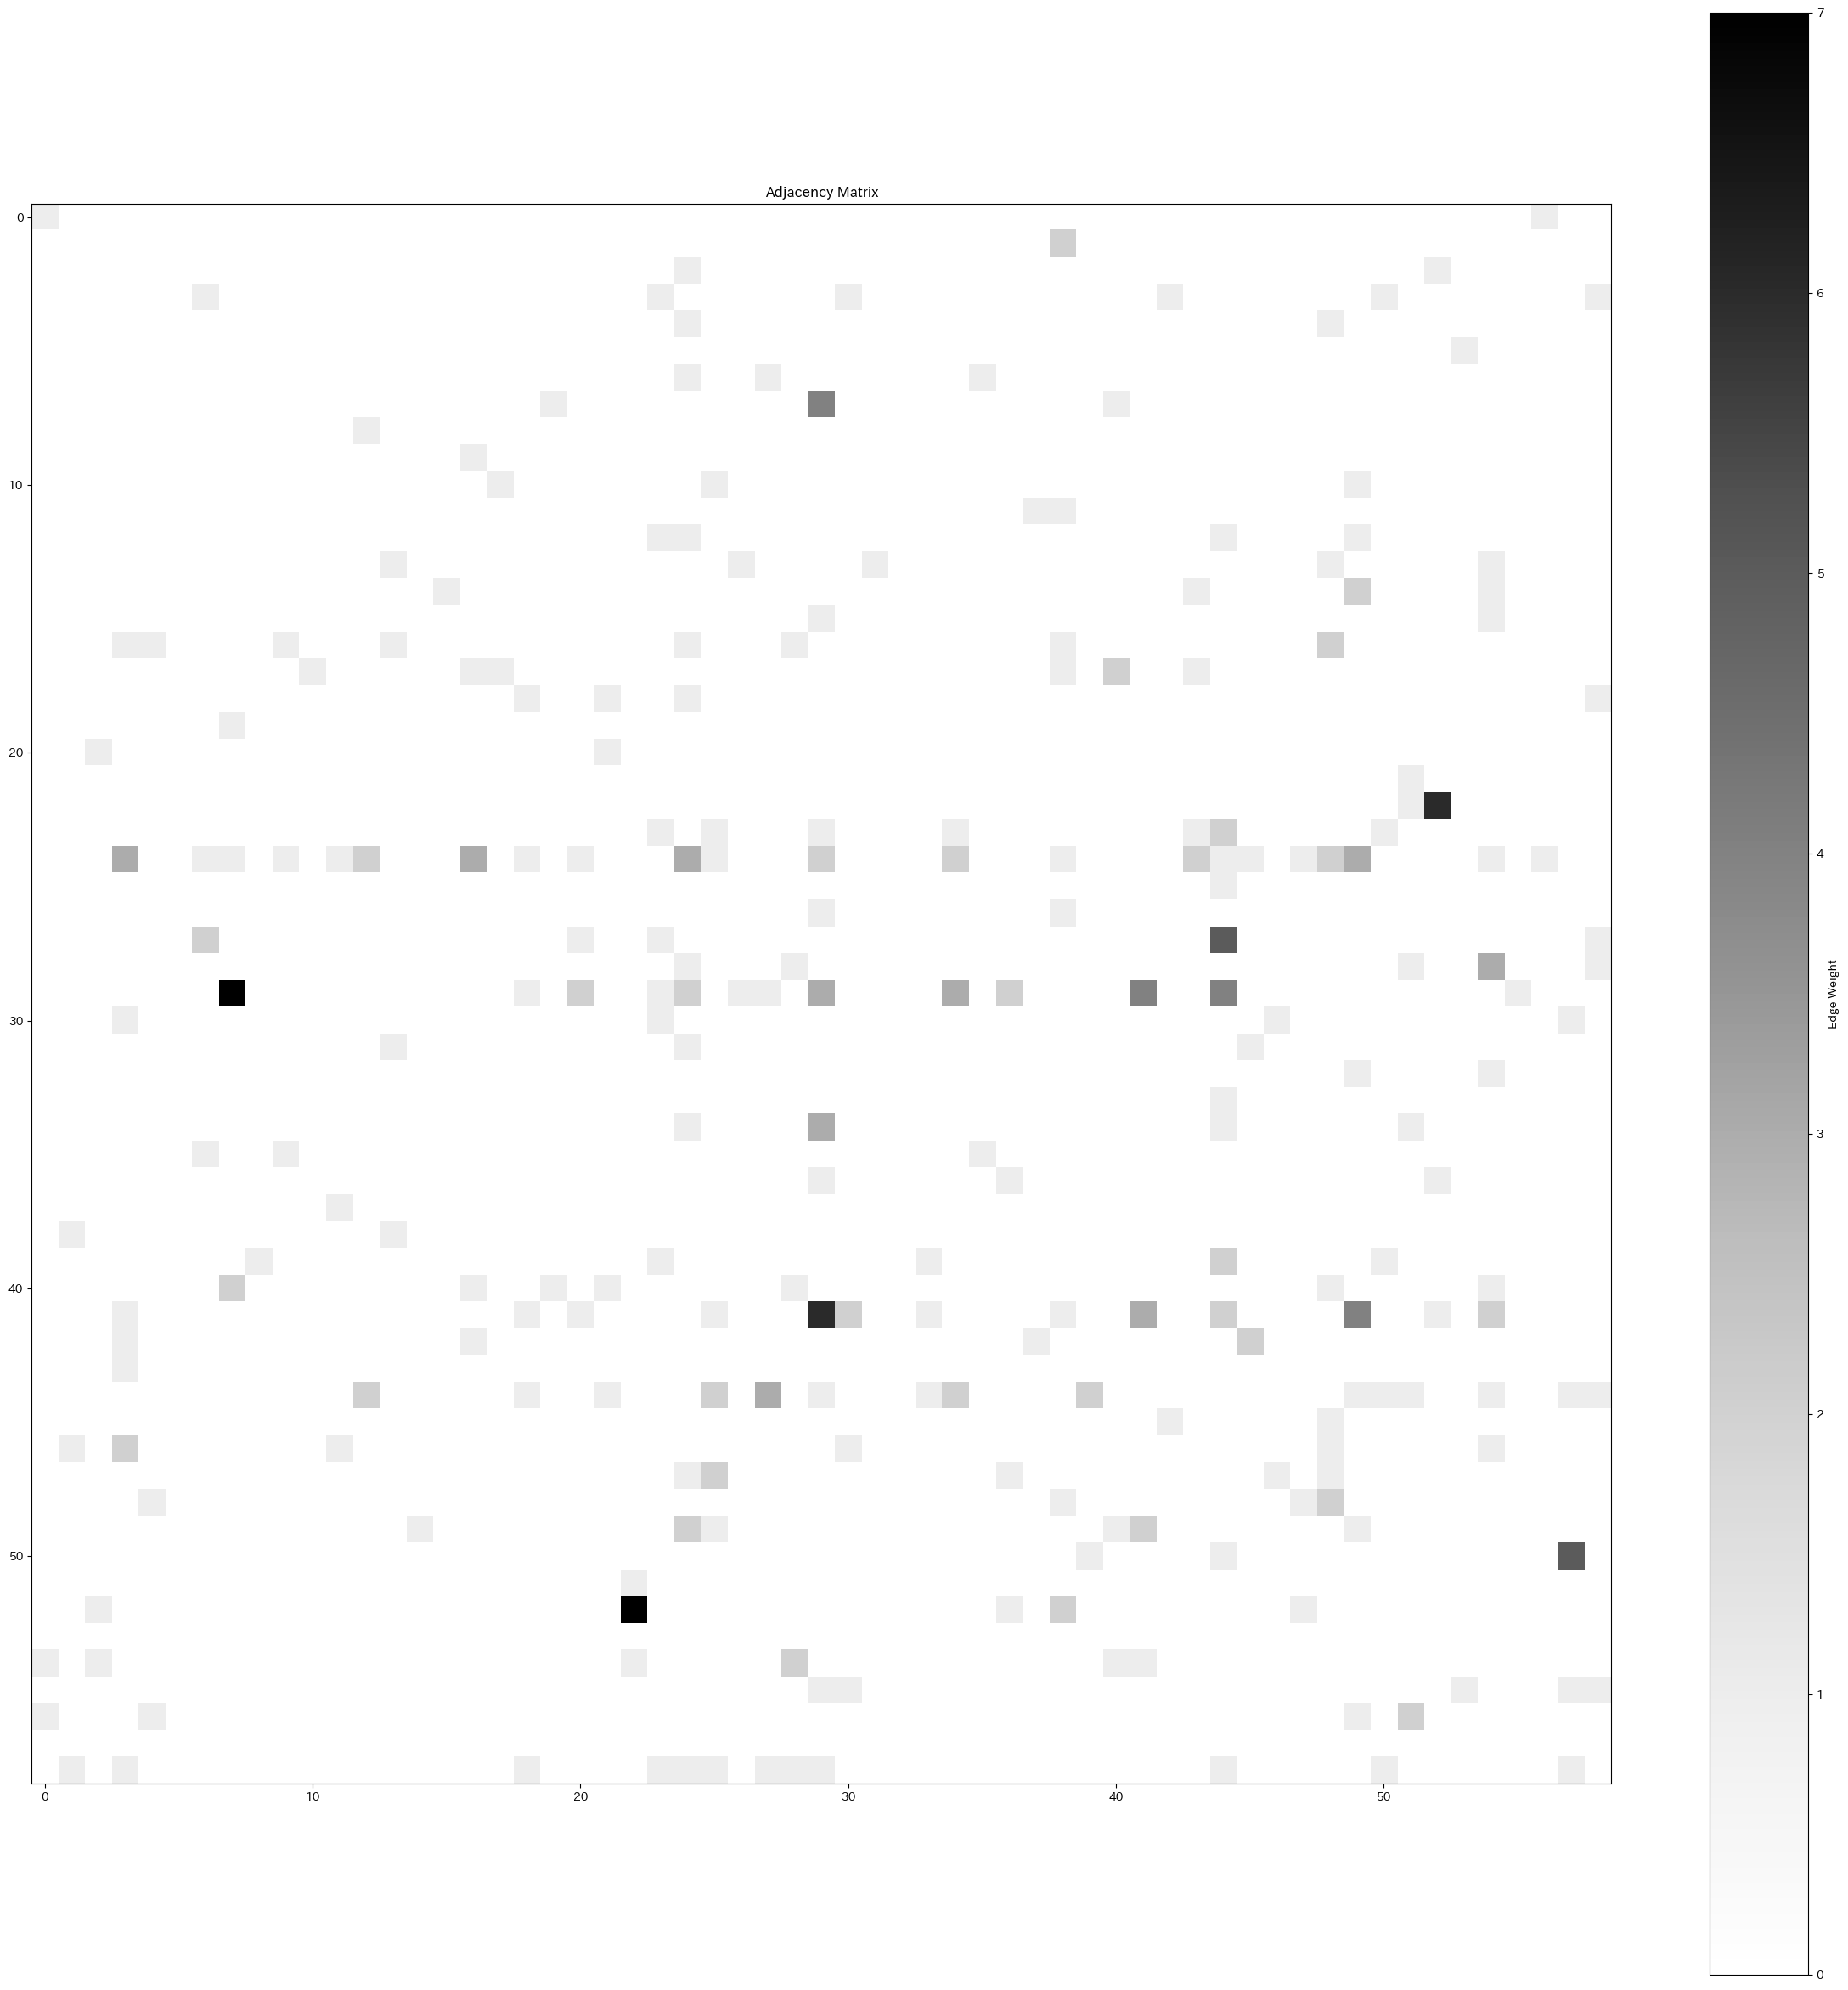

In [8]:
A = nx.adjacency_matrix(G, nodelist=target_ids).toarray()
plt.figure(figsize=(30,30))  # サイズ調整
plt.imshow(A, cmap='Greys')  # 隣接行列の描画。'Greys'は色スキーマ。
plt.colorbar(label='Edge Weight')  # カラーバーの追加
plt.title('Adjacency Matrix')  # タイトル
plt.show()

# 推論

In [14]:
A = nx.adjacency_matrix(G, nodelist=target_ids).toarray()
A[A >= 1] = 1

# https://forum.pyro.ai/t/stochastic-block-model-using-pyro/2405
def model(A, K):
  # Network Nodes
  n = A.shape[0]

  # Block Matrix Eta
  with numpyro.plate("eta1", K):
    with numpyro.plate("eta2", K):
      eta = numpyro.sample("eta", dist.Beta(1., 1.))

  # Group Memberships (Using a Multinomial Model)
  membership_probs = numpyro.sample("z_probs", dist.Dirichlet(concentration=jnp.ones(K)))
  with numpyro.plate("membership", n):
    sampled_memberships = numpyro.sample("sampled_z", dist.Categorical(probs=membership_probs))
    sampled_memberships = jax.nn.one_hot(sampled_memberships, K)

  # Adjacency Matrix
  p = jnp.matmul(jnp.matmul(sampled_memberships, eta), sampled_memberships.T)
  with numpyro.plate("rows", n):
    with numpyro.plate("cols", n):
      A_hat = numpyro.sample("A_hat", dist.Bernoulli(p), obs=A)

K = 2

# Inference
kernel = DiscreteHMCGibbs(NUTS(model))
mcmc = MCMC(kernel, num_warmup=500, num_samples=1000)
mcmc.run(jax.random.PRNGKey(0), A, K)
mcmc.print_summary()
Z_infer = mcmc.get_samples()["sampled_z"]
Z_infer = Z_infer[-1].tolist()
print("Inference Result", Z_infer)

sample: 100%|██████████| 1500/1500 [00:10<00:00, 138.83it/s, 7 steps of size 4.47e-01. acc. prob=0.92]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     eta[0,0]      0.04      0.01      0.04      0.04      0.05    253.85      1.00
     eta[0,1]      0.11      0.02      0.11      0.08      0.15    528.60      1.00
     eta[1,0]      0.18      0.03      0.17      0.12      0.24    220.96      1.00
     eta[1,1]      0.50      0.10      0.50      0.32      0.66    234.63      1.00
 sampled_z[0]      0.00      0.00      0.00      0.00      0.00       nan       nan
 sampled_z[1]      0.00      0.00      0.00      0.00      0.00       nan       nan
 sampled_z[2]      0.00      0.00      0.00      0.00      0.00       nan       nan
 sampled_z[3]      0.27      0.45      0.00      0.00      1.00    291.50      1.00
 sampled_z[4]      0.00      0.00      0.00      0.00      0.00       nan       nan
 sampled_z[5]      0.00      0.00      0.00      0.00      0.00       nan       nan
 sampled_z[6]      0.00      0.00      0.00      0.00      0.00       nan  

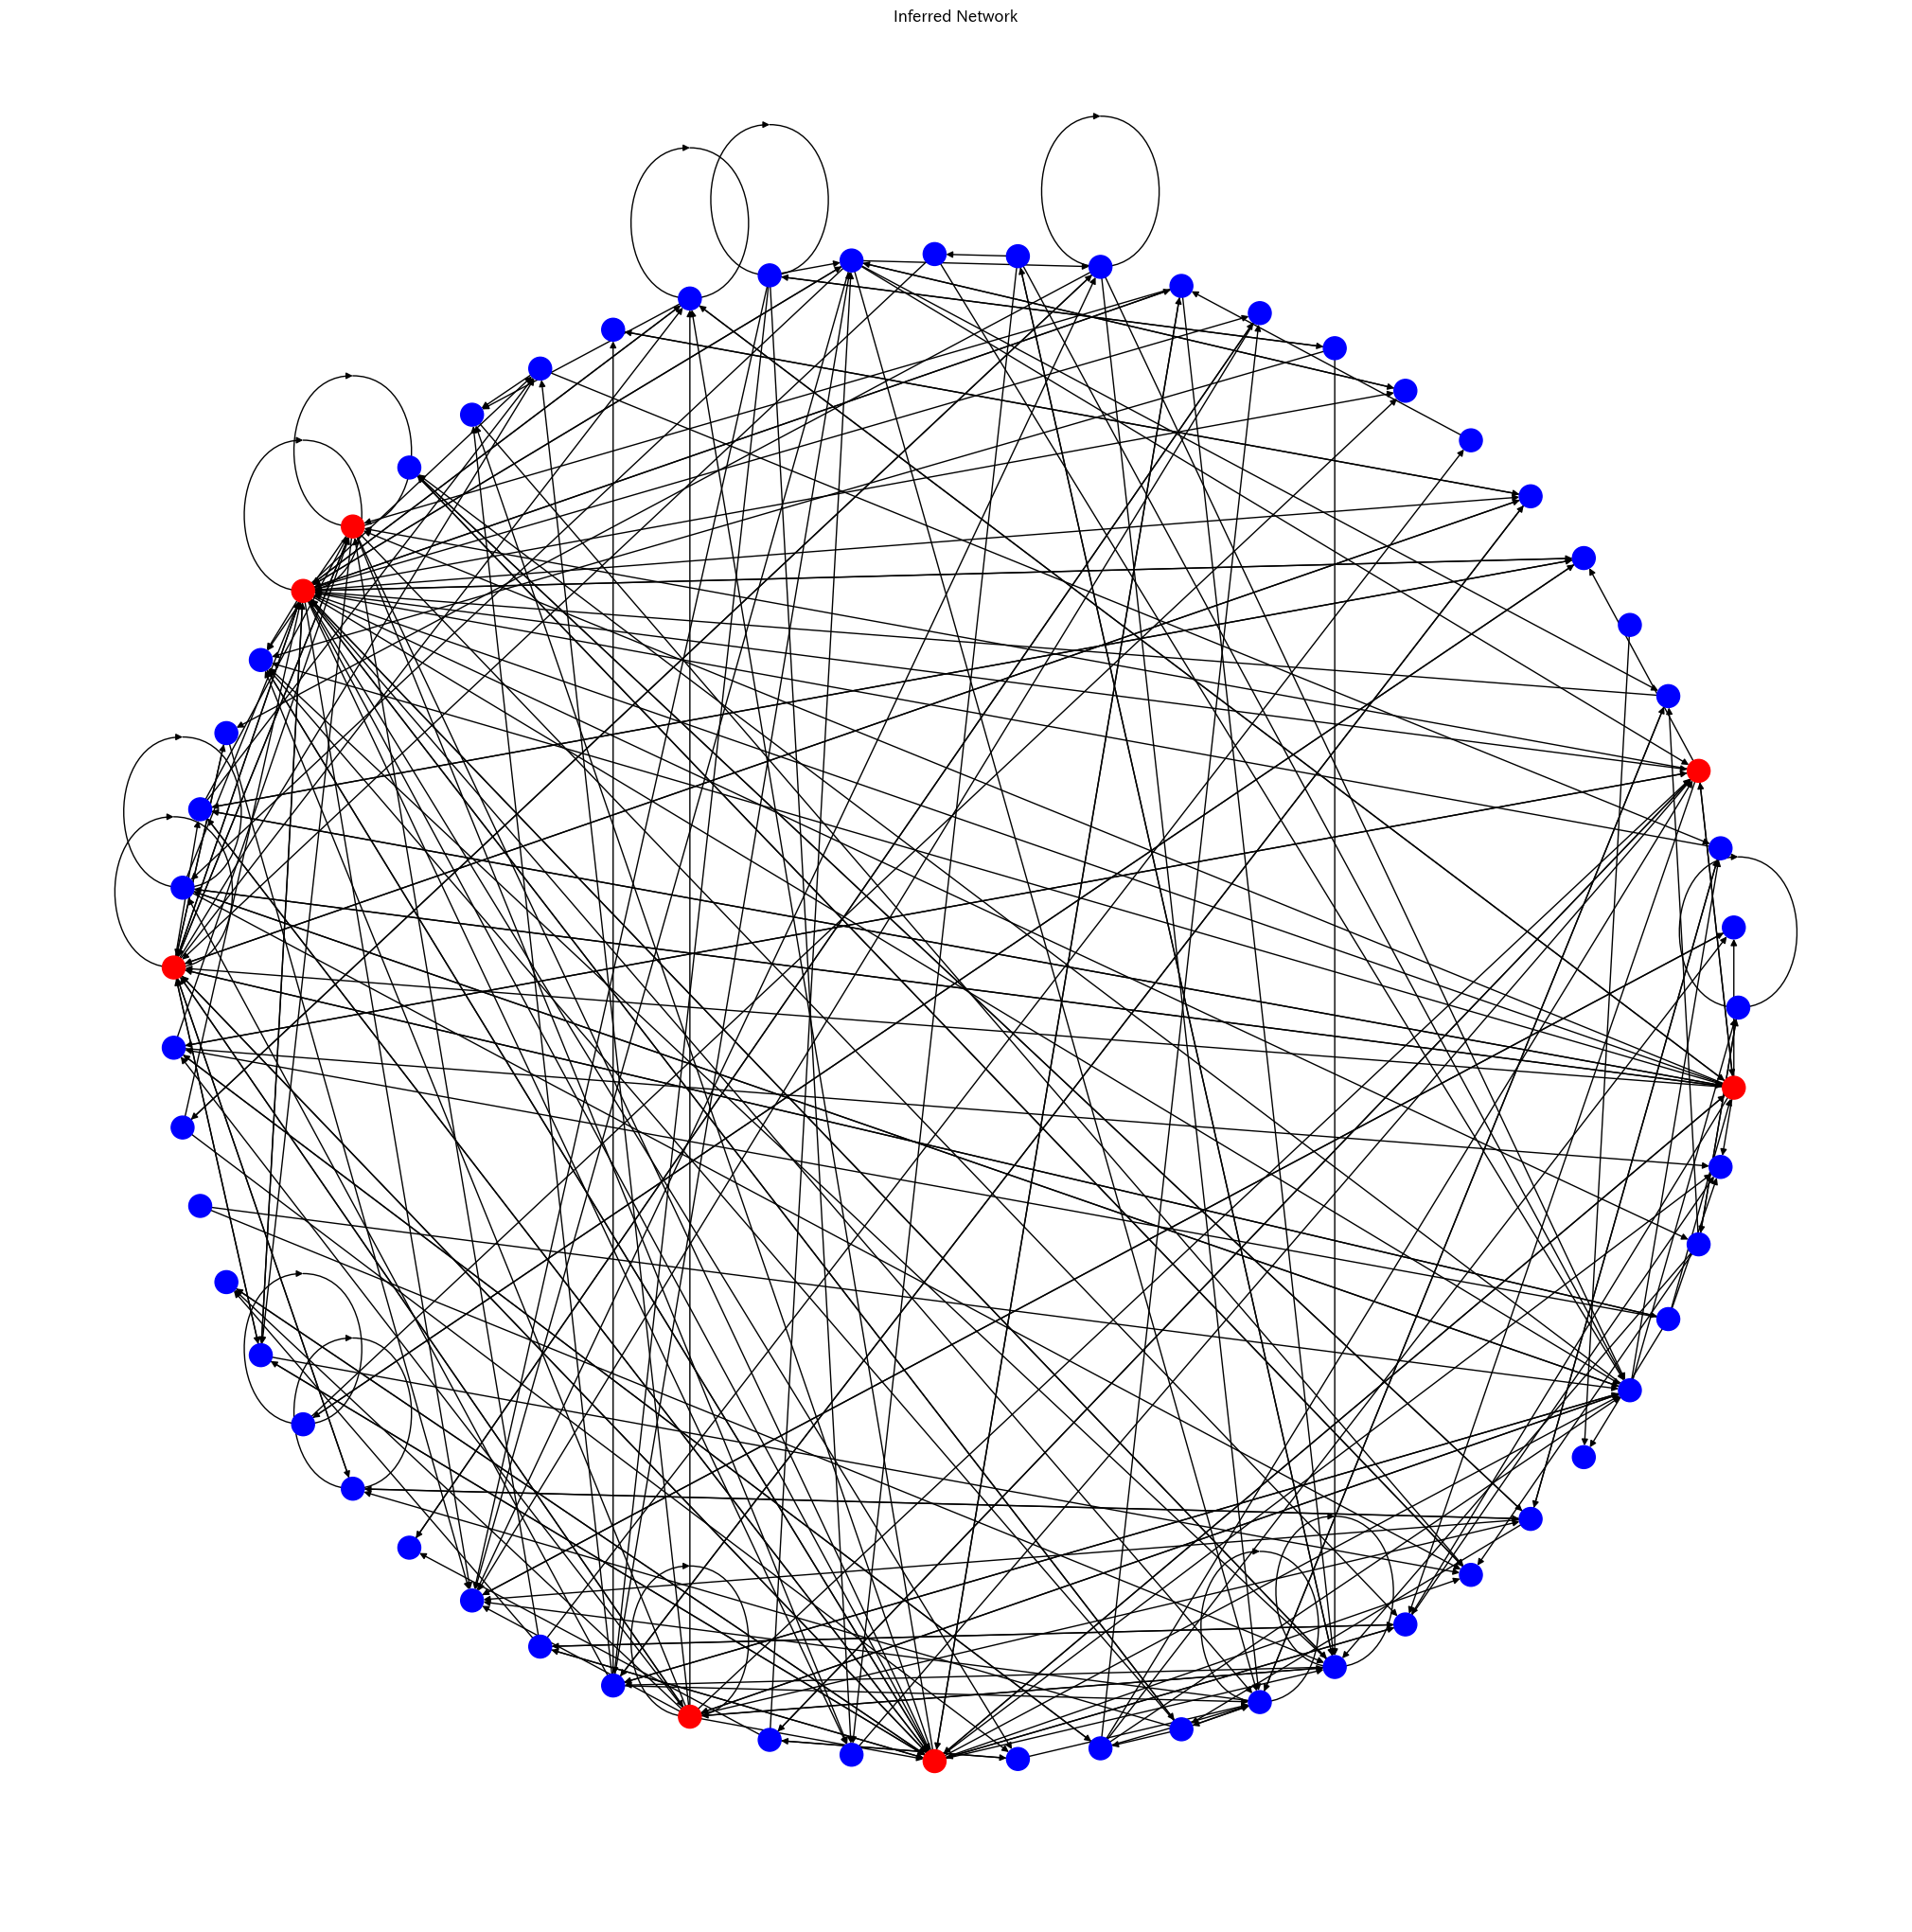

In [15]:
colors = {
    0: "blue",
    1: "red",
    2: "green",
}

# Visualization
G = nx.DiGraph(np.array(A))
plt.figure(figsize=(20,20))
nx.draw(G, pos=nx.circular_layout(G), node_color=[colors[g] for g in Z_infer])
plt.title("Inferred Network")
plt.show()

In [16]:
pd.options.display.max_colwidth = 500
pd.options.display.max_rows = 100

groups = pd.DataFrame({"id": target_ids, "group": Z_infer})

for group in range(K):
  display(group)
  group_ids = groups[groups["group"] == group]["id"].unique().tolist()
  display(df[df["id"].isin(group_ids) & df["responses"].apply(len)>0][["id", "body"]].drop_duplicates("id"))

0

,id,body
29,ID: 9Qe3B+yoKG,あんなに入るマガジンねーよってほうがはやいとおもうんだがなあライフルのズームのシーンはキャラの顔見せもあるだろうしドローン落とすシーンは弾道描写にコスト割くよりその後の戦闘シーンのほうが重要だし、音を立てたことを見せる演出なわけだから弾道にこだわる理由は薄い、むしろ直線的じゃない分、音の表現に対してノイズになることも考えられる音が響くのを見せるわけだから冗長なタイムロスは抑えたいカットイン砂嵐で正解じゃね？
35,ID: 0yxJP7iKe+,リロードするシーンでスロットが一つ余計に空いてるので、乱射してる間にしれっと一回リロードしてる
40,ID: K1eqxDt2JW,みたいなのも銃に疎い自分にはそこそこおもろい、まあ俺ならもっと上手く出来るとかこう描写するべきみたいのは頂けないが
56,ID: MwkZ3V+bHE,アイキャッチを深読みしたらちさととたきなが対立してどちらかが現行社会の破壊を試みる展開はありそうな気がする。その場合DA側に立つのは酸いも甘いも知ってなお今の立ち位置に居そうなちさとで、破壊者側になるのは思い切りがよくて極論に走りそうなたきなかなとも思う。まあ全部妄想だから実際は普通に仲良くバディ物をするんだろうけども。
148,ID: pOgKOI1nnt,威力はないけど一応たきなの方法でも飛ばせる、パチンコに近い感じ
163,ID: qJK5yUBWh4,女の子ばかりでパンパンバトルさせときゃお前ら見るんだろ？っていうマーケティングかもしれんけど、きちんと設定として落とし込んでおいて欲しいよねサツバツな世界観だしよくネタで言われる「男は戦場送りされました」がホントな世界かもしれんけど
186,ID: WyMH+NzC/s,上田麗奈かと思ったら安斉知佳だった……。>>なんか、最近そんな感じの作品を見た気がしたんだが、思い出せん……。自分もうえしゃまが最初に出てきたな、声の感じとキャラクターの外面はいいけどどこかサイコパスっぽいオーラが倫理観ゆるふわ系美少女新条アカネを思い出させた。笑顔で人を○して呵責がない系のキャラってダークな作品に多いしね。ただ今のとこの千束のイメージはだいぶ変わっててサイコパスじゃなくて剣心になったな
214,ID: QmEiWh+QTX,わかる百合ハッピーエンドも丁度飽きてたし虐殺器官くらい仲違いからのクソみたいな死別と最悪のエンディング迎えてほしい！
243,ID: eBCnEfpPg8,どこの世紀末？
247,ID: MdS4V2dTZR,自衛隊がそんな感じだった殺人が得意だったり好きな人が集まると自然と犯罪者の集まりっぽくなるあえて強姦が好みだったりする奴とか女に媚薬盛る奴とかどうすれば同僚を合法的に殺す事が出来るか考えてる奴とかそういう奴がそういう奴であるが故に尊敬されて人の上に立ったり褒められたりするし組織の経営理念や教育的にも殺人は善とするように思えたそれを国が認めているんだから、「人を殺してはいけない」っていうのは一般国民に対しての道徳であって殺す側の人間にとっては積極的に行うべき善行ですらあるんじゃないかと思っただからリコリスが報いを受ける事は無いと思う


1

,id,body
168,ID: DJF83CWeVb,同感だわ「JKが日本の治安を守ってる」とリアルで言ったら鼻で笑われるのを逆手にとって大真面目に実行してるっていう部分が「そういうもの」として見れるようになってるある種架空のニンジャとかスパイものの延長とも言えるかもただ現時点だと本編の敵が女の子に全然物怖じせず容赦なく撃ってくるから機能してないように見えちゃってるけど実際は１話アバンみたいなのが大多数なんだろう・・・
619,ID: HiekEUW+Ku,あんたが書いてる本人かは知らんが複数人が競うように書いてた時点でどうせ他のミリオタが気持ち悪い長文書くのは目に見えてるしな 会話相手として発散する場所がニコ動のコメぐらいしかないんだろうしこちらとしてはありがたいが勝手にしてくれコメントを消したほうがいいってのはぐうの音もでない正論だと思うし、そこに異論はない見るときはコマンドshitaを消すことにするわ ありがとう
658,ID: Ah3oG60xxb,特殊カーボンみたいなのがあるかもしれないし…
1257,ID: 96xnTUaRNp,さすがツッコんどくけど逆で、パトレイバーは一貫して野明の物語であって、劇中の事件や内海の陰謀なんかは傍流であり野明の触媒であり話を展開するためのギミックなのよなのでテンプレから外れる例として不適切
1301,ID: 0ymNDB/igS,バランスをとらなくっちゃなあ！
2032,ID: BQKX5zac/P,弾が当たらなくともあのままならたきなは落ちるしかないしね。逆にどの辺が雑に感じたのかがまったく想像できないが...
2276,ID: 2pjyJThKtb,飲んでみ？って差し出したの千束からだから真島が責められてるの理不尽で草あそこで「い、要らねぇよ！！」なんて言ったら真島が童貞っぽくてカッコ悪いしそもそも部屋に侵入して映画の談笑した時点で百合の邪魔をさんざんしてるしなww
